In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [48]:
os.chdir('C:\\Users\\Hp\\OneDrive\\Documents\\GitHub\\Thoucentric\\DataSets')

In [49]:
df=pd.read_csv('Iceus_sugar_all.csv')
df

,date,low,high,close,open
0,2017-01-03T00:00:00.000Z,19.58,20.55,20.51,19.63
1,2017-01-04T00:00:00.000Z,20.41,20.94,20.89,20.55
2,2017-01-05T00:00:00.000Z,20.66,21.18,20.78,20.89
3,2017-01-06T00:00:00.000Z,20.30,20.84,20.75,20.66
4,2017-01-09T00:00:00.000Z,20.36,20.75,20.42,20.74
...,...,...,...,...,...
2067,2024-06-17T00:00:00.000Z,18.81,19.32,18.98,18.93
2068,2024-06-18T00:00:00.000Z,18.81,19.19,18.92,18.93
2069,2024-06-19T00:00:00.000Z,18.81,19.19,18.92,19.10
2070,2024-06-20T00:00:00.000Z,18.82,19.43,18.89,18.92


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2072 non-null   object 
 1   low     2072 non-null   float64
 2   high    2072 non-null   float64
 3   close   2072 non-null   float64
 4   open    2071 non-null   float64
dtypes: float64(4), object(1)
memory usage: 81.1+ KB


In [51]:
df.index=pd.to_datetime(df['date'], format='ISO8601')
df=df.drop(columns=['date'])
df.head()

,low,high,close,open
date,,,,
2017-01-03 00:00:00+00:00,19.58,20.55,20.51,19.63
2017-01-04 00:00:00+00:00,20.41,20.94,20.89,20.55
2017-01-05 00:00:00+00:00,20.66,21.18,20.78,20.89
2017-01-06 00:00:00+00:00,20.30,20.84,20.75,20.66
2017-01-09 00:00:00+00:00,20.36,20.75,20.42,20.74


In [52]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [53]:
windowsize=5
X, y= df_to_X_y(df, windowsize)
X,y

(array([[[[19.58, 20.55, 20.51, 19.63]],
 
         [[20.41, 20.94, 20.89, 20.55]],
 
         [[20.66, 21.18, 20.78, 20.89]],
 
         [[20.3 , 20.84, 20.75, 20.66]],
 
         [[20.36, 20.75, 20.42, 20.74]]],
 
 
        [[[20.41, 20.94, 20.89, 20.55]],
 
         [[20.66, 21.18, 20.78, 20.89]],
 
         [[20.3 , 20.84, 20.75, 20.66]],
 
         [[20.36, 20.75, 20.42, 20.74]],
 
         [[20.15, 20.56, 20.48, 20.5 ]]],
 
 
        [[[20.66, 21.18, 20.78, 20.89]],
 
         [[20.3 , 20.84, 20.75, 20.66]],
 
         [[20.36, 20.75, 20.42, 20.74]],
 
         [[20.15, 20.56, 20.48, 20.5 ]],
 
         [[20.48, 20.89, 20.56, 20.55]]],
 
 
        ...,
 
 
        [[[19.27, 19.6 , 19.43, 19.49]],
 
         [[19.27, 19.6 , 19.43, 19.49]],
 
         [[19.27, 19.6 , 19.43, 19.32]],
 
         [[18.81, 19.32, 18.98, 18.93]],
 
         [[18.81, 19.19, 18.92, 18.93]]],
 
 
        [[[19.27, 19.6 , 19.43, 19.49]],
 
         [[19.27, 19.6 , 19.43, 19.32]],
 
         [[18.81, 19.32, 

In [54]:
X=X.reshape(X.shape[0], X.shape[1], X.shape[3])
X.shape, y.shape

((2067, 5, 4), (2067, 4))

In [55]:
X_train, y_train = X[:1800], y[:1800]
X_val, y_val = X[1800:1950], y[1800:1950]
X_test, y_test = X[1950:], y[1950:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1800, 5, 4), (1800, 4), (150, 5, 4), (150, 4), (117, 5, 4), (117, 4))

In [56]:
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import *

In [57]:
model = Sequential()
model.add(InputLayer((windowsize, X_train.shape[2])))  # (5, 4)
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))  # 15 features in the output
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17664     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
Total params: 18,220
Trainable params: 18,220
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=110)

Epoch 1/110
57/57 [==============================] - 2s 12ms/step - loss: 190.1438 - root_mean_squared_error: 13.7893 - val_loss: 317.8972 - val_root_mean_squared_error: 17.8297
Epoch 2/110
57/57 [==============================] - 0s 4ms/step - loss: 64.5262 - root_mean_squared_error: 8.0328 - val_loss: 151.4173 - val_root_mean_squared_error: 12.3052
Epoch 3/110
57/57 [==============================] - 0s 3ms/step - loss: 25.3945 - root_mean_squared_error: 5.0393 - val_loss: 93.6945 - val_root_mean_squared_error: 9.6796
Epoch 4/110
57/57 [==============================] - 0s 3ms/step - loss: 17.4215 - root_mean_squared_error: 4.1739 - val_loss: 72.0581 - val_root_mean_squared_error: 8.4887
Epoch 5/110
57/57 [==============================] - 0s 3ms/step - loss: 8.8215 - root_mean_squared_error: 2.9701 - val_loss: 42.0304 - val_root_mean_squared_error: 6.4831
Epoch 6/110
57/57 [==============================] - 0s 3ms/step - loss: 3.9684 - root_mean_squared_error: 1.9921 - val_loss: 25.

In [59]:
def compute_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    bias = np.mean(predicted - actual)
    variance = np.var(predicted - actual)

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
        'Bias': bias,
        'Variance': variance
    }
    
    return metrics

In [60]:
train_predictions = model.predict(X_train).flatten()
ytrain1= y_train.flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals': ytrain1})
train_results

57/57 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,20.242188,20.15
1,20.758821,20.56
2,20.506384,20.48
3,20.492445,20.50
4,20.209467,20.48
...,...,...
7195,26.081543,26.24
7196,25.776794,25.95
7197,26.446590,26.85
7198,26.141893,26.73


In [61]:
compute_metrics(ytrain1, train_predictions)

{'MSE': 0.04498370118092158,
 'RMSE': 0.21209361419175632,
 'MAE': 0.1489545031229655,
 'R² Score': 0.997490868256182,
 'Bias': 0.022159537114037408,
 'Variance': 0.044492656095813175}

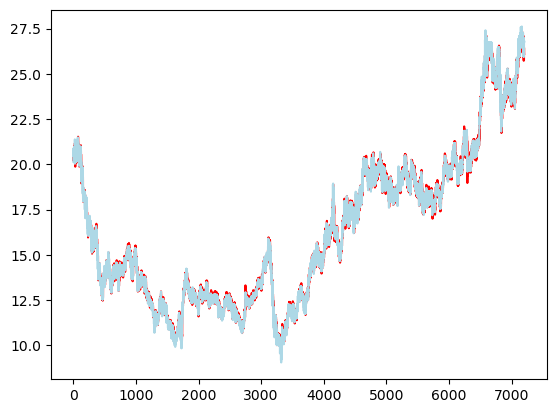

In [62]:
plt.plot(train_results['Train Predictions'][:], color= 'red')
plt.plot(train_results['Actuals'][:], color= 'lightblue')

In [63]:
val_predictions= model.predict(X_val).flatten()
y_val1=y_val.flatten()
val_results=pd.DataFrame(data={'Val Predictions': val_predictions, 'Val Actuals': y_val1})
val_results

5/5 [==============================] - 0s 1ms/step


,Val Predictions,Val Actuals
0,26.169655,26.20
1,26.826418,26.80
2,26.472561,26.27
3,26.460516,26.77
4,26.081827,26.20
...,...,...
595,22.689104,22.70
596,22.420055,22.56
597,22.995701,23.08
598,22.720314,22.62


In [64]:
compute_metrics(y_val1, val_predictions)

{'MSE': 0.1407214942368474,
 'RMSE': 0.37512863691918724,
 'MAE': 0.2777336949666341,
 'R² Score': 0.9765008692522725,
 'Bias': -0.09391516062418613,
 'Variance': 0.13190143684178074}

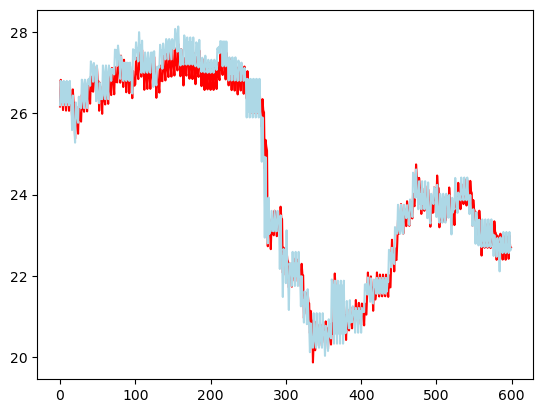

In [65]:
plt.plot(val_results['Val Predictions'][:], color='red')
plt.plot(val_results['Val Actuals'][:], color='lightblue')

In [66]:
test_predictions = model.predict(X_test).flatten()
ytest1=y_test.flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Test Actuals': ytest1})
test_results=test_results.dropna()
test_results.head()

4/4 [==============================] - 0s 2ms/step


,Test Predictions,Test Actuals
0,22.414530,22.45
1,22.985325,23.45
2,22.701059,23.15
3,22.684792,23.24
4,22.928963,23.12


In [67]:
compute_metrics(test_results['Test Actuals'], test_results['Test Predictions'])

{'MSE': 0.10005957470511666,
 'RMSE': 0.3163219478713367,
 'MAE': 0.21206543965309024,
 'R² Score': 0.960592860588067,
 'Bias': 0.035384361218078766,
 'Variance': 0.09880752168630522}

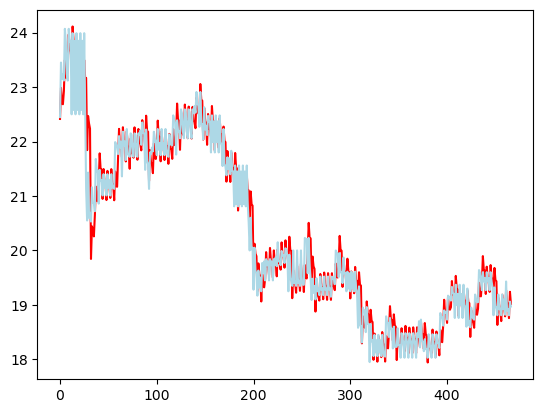

In [68]:
plt.plot(test_results['Test Predictions'][:], color='red')
plt.plot(test_results['Test Actuals'][:], color='lightblue')

In [69]:
future_days=45
forecast_date=pd.date_range(list(df.index)[-1], periods=future_days, freq='B').tolist()
forecast=model.predict(X[-future_days:])

2/2 [==============================] - 0s 3ms/step


In [70]:
forecast_copied=np.repeat(forecast, X.shape[1], axis=-1)
y_pred_futures=forecast_copied[:, 0]

In [71]:
dates=[]
for i in forecast_date:
    dates.append(i.date())

In [72]:
df_forecast=pd.DataFrame({'Date': np.array(dates), 'Open': y_pred_futures})

In [74]:
original=df[['open']]
original['date']=pd.to_datetime(df.index)
original=original.loc[original['date']>='2024-02-01']

C:\Users\Hp\AppData\Local\Temp\ipykernel_14996\2887319462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(df.index)


Text(0, 0.5, 'Open Price')

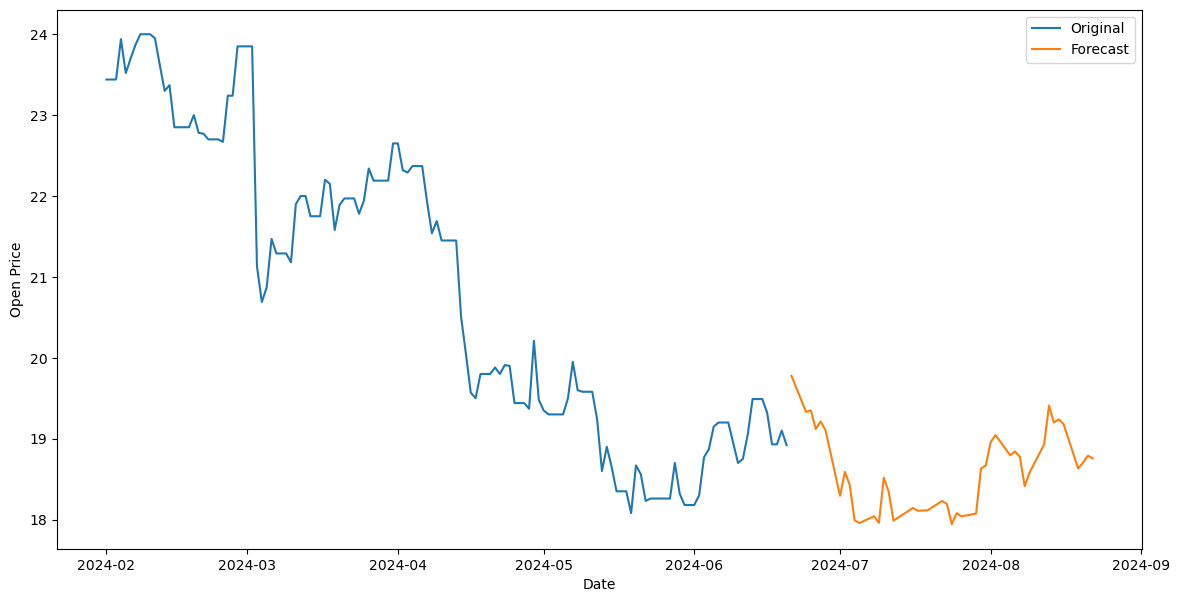

In [75]:
import seaborn as sns
plt.figure(figsize=(14, 7))
sns.lineplot(x=original['date'], y=original['open'], label='Original')
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')